<a href="https://colab.research.google.com/github/i-am-hrushi/Cricket-Highlight-Generation-Using-Computer-Vision/blob/main/main_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and Import Required Libraries 

In [ ]:
!pip install easyocr

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import cv2
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import TensorBoard
from google.colab import output

from sklearn.model_selection import train_test_split as tts

import easyocr

Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# CNN for classification

In [ ]:
#Import train data
path2 = '/content/drive/MyDrive/AML_project_files/train_Data.npy'
train_data = np.load(path2, allow_pickle=True)

In [ ]:
# Grayscale the images for CNN 
gray_train_data = []
for i in range(len(train_data)):
    gray_train_data.append(cv2.cvtColor(train_data[i][0], cv2.COLOR_BGR2GRAY))

In [ ]:
# Split X & y
X = []
y = []
for i in range(train_data.shape[0]):

    X.append(gray_train_data[i])
    y.append(train_data[:][i][1])

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.3, stratify=y)

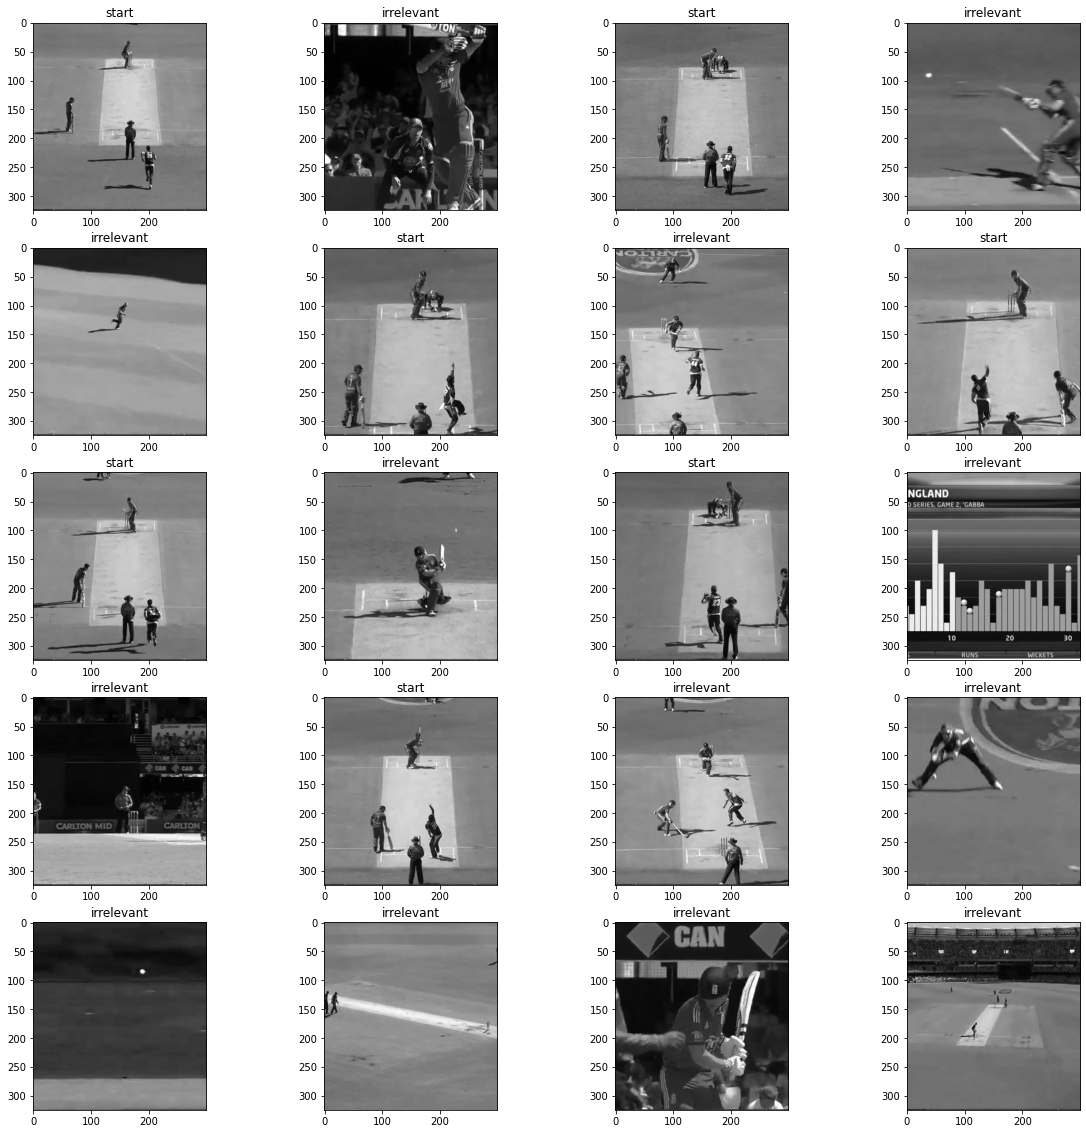

In [ ]:
# Sample images for illiustration
count = 0
Num_of_Images = 20
plt.figure(figsize=(20,20))
for i in np.random.randint(1000, size = Num_of_Images):
    count = count+1
    plt.subplot(Num_of_Images/4,4, count)
    plt.imshow(X_train[i], cmap='gray')
    P = y_train[i]
    if(P[0]==1):
        plt.title('start')
    else:
        plt.title('irrelevant')

Constructing CNN Model 

In [ ]:
# Input layer
img_input = layers.Input(shape=(325, 300, 1))

# Convolution layers
x = layers.Conv2D(8, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and hidden units
x = layers.Dense(5096, activation='relu')(x)
x = layers.Dense(1024, activation='relu')(x)

# Output layer
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
model = Model(img_input, output)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 325, 300, 1)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 323, 298, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 161, 149, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 159, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 79, 73, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 77, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 38, 35, 64)        0     

In [ ]:
# Define checkpoint path
checkpoint_path = "/content/drive/MyDrive/AML_project_files/checkpoint_grayscale_images/cp_gray.ckpt"

# Create a callback that saves the model's weights
cp_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True, verbose=1)

model.compile(loss='binary_crossentropy',  optimizer= 'adam',   metrics=['accuracy']);

In [ ]:
hist = model.fit(X_train,y_train, batch_size =32, epochs = 8, verbose=1,callbacks=[cp_callback], validation_data=(X_test, y_test))

Epoch 1/8
42/42 [==============================] - 138s 3s/step - loss: 144.2267 - accuracy: 0.7525 - val_loss: 0.1351 - val_accuracy: 0.9547

Epoch 00001: saving model to /content/drive/MyDrive/AML_project_files/checkpoint_grayscale_images/cp_gray.ckpt
Epoch 2/8
42/42 [==============================] - 144s 3s/step - loss: 0.0978 - accuracy: 0.9720 - val_loss: 0.1221 - val_accuracy: 0.9669

Epoch 00002: saving model to /content/drive/MyDrive/AML_project_files/checkpoint_grayscale_images/cp_gray.ckpt
Epoch 3/8
42/42 [==============================] - 165s 4s/step - loss: 0.0391 - accuracy: 0.9945 - val_loss: 0.1516 - val_accuracy: 0.9495

Epoch 00003: saving model to /content/drive/MyDrive/AML_project_files/checkpoint_grayscale_images/cp_gray.ckpt
Epoch 4/8
42/42 [==============================] - 183s 4s/step - loss: 0.0179 - accuracy: 0.9964 - val_loss: 0.2523 - val_accuracy: 0.9355

Epoch 00004: saving model to /content/drive/MyDrive/AML_project_files/checkpoint_grayscale_images/cp_

In [ ]:
# Loading the pre-trained weights
model.load_weights( "/content/drive/MyDrive/AML_project_files/checkpoint_grayscale_images/cp_gray.ckpt")

# OCR for scoreboard reading

Define function that reads OCR

In [ ]:
def scoreboard(frame):
    crop_score= frame[300:350, 135:190]
    present = False

    try:
        score = reader.readtext(crop_score,detail=0)[-1]
        if '/'in score:
            wickets = int(score.split('/')[0])
            runs = int(score.split('/')[1])
            present = True
        else:
            wickets = None
            runs = None
    except:
        present = False
        wickets = None
        runs = None
    
    return [present, runs, wickets]

# Main Function 

In [ ]:
def main():

    # 1.Load video
    vidcap = cv2.VideoCapture('video_2.mp4')
    time_stamps_final = []
    time_stamps_final_start_to_start = []                                       # Initiating time-stamp var and return after complete video processing is done

    # 2. Extract frames and set the current start
    flag = 0                                                                    # Variable for setting current start
    frames_current_start_to_future_start = []                                   # frames from current start to future start for processing
    frame_no = 0
    while flag==0:
        success, frame = vidcap.read()                                          # read first frame of video
        frame_no +=1                                                            # set counter for frame number to save timestamps

        moving_average_for_start_ball = []
        
        # Detect if scoreboard is present, if yes then start Detecting start-of-ball

        # Detect if scoreboard is present: if yes, then: {execute below lines}, else skip to next frame
        while (len(moving_average_for_start_ball)<3):
            
            # Is scoreboard present in frame, if yes, the proceed, else clear moving_average list, skip frames and re-iterate
            if scoreboard(frame)[0] == False:
                moving_average_for_start_ball.clear()
                for _ in range(5):
                    success, frame = vidcap.read()                              # Skip by 5 frames
                    frame_no+=1
                    if success==False:
                        break
                continue
                            
            # Crop and convert to grayscale images for classification.
            gray_frame_cropped = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY )[:325, 150:450]
            prediction_to_start = model.predict(gray_frame_cropped.reshape(1, 325, 300))   #classify frame
            moving_average_for_start_ball.append( 1 if prediction_to_start[0][0]>0.5  else 0) # append list
            
            if len(moving_average_for_start_ball)==3:
                if sum(moving_average_for_start_ball)>=2:
                    current_start = frame_no  
                    print("current start:", current_start)
                    current_runs = scoreboard(frame)[1]                         #  read current score from ocr
                    current_wickets = scoreboard(frame)[2]                      #  read current wickets from ocr
                    frames_current_start_to_future_start.append(frame)                    
                    flag = 1
                    break
                
                else:
                    del moving_average_for_start_ball[0]
                    for _ in range(5):
                        success, frame = vidcap.read()                          # Skip by 5 frames
                        frame_no+=1
                        if success==False:
                            break
                    

        
    for _ in range(5):
        success, frame = vidcap.read()                                          # Skip by 5 frames
        frame_no+=1
        if success == False:
            break;
    frames_current_start_to_future_start.append(frame)


    # 3. Extract furthur frames, Detect the start of the ball and Set the future start.
    while success:
            
        # start detecting start-of-ball
        moving_average_for_start_ball.clear()
        while (len(moving_average_for_start_ball)<3):

            if scoreboard(frame)[0] == False:                                   # Check prsesence of scoreboard  
                moving_average_for_start_ball.clear()                   
                for _ in range(5):
                    success, frame = vidcap.read()                              # Skip by 5 frames
                    if not success:
                        break;
                    frame_no+=1
                frames_current_start_to_future_start.append(frame)
                continue

            prediction_to_start = model.predict(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY )[:325, 150:450].reshape(1, 325, 300))   # classify frame using CNN model
            moving_average_for_start_ball.append( 1 if prediction_to_start[0][0]>0.5 else 0)                                    # append moving average
            
            if len(moving_average_for_start_ball)==3:

                if sum(moving_average_for_start_ball)>=2:
                    future_start = frame_no  
                    future_runs = scoreboard(frame)[1]                          # read future score from ocr
                    future_wickets = scoreboard(frame)[2]                       # read future wickets
                    frames_current_start_to_future_start.append(frame)                    
                    break
            
                else:
                    del moving_average_for_start_ball[0]

            for _ in range(5):
                success, frame = vidcap.read()                                  # Skip by 5 frames
                if not success:
                    break;
                frame_no+=1 
            frames_current_start_to_future_start.append(frame)       
        if not success:
            break;
        

        
        # 4. Read score and check if there is an important event note the time stamp.

        runs_diff = future_runs - current_runs
        wickets_diff = future_wickets - current_wickets
        if (runs_diff==4 or runs_diff==6) or wickets_diff==1:
            time_stamps_final_start_to_start.append([current_start, future_start])
            print("EVENT DETECTED")
            # start detecting current end
            if runs_diff ==4:
                print("ITS A FOUR")
                for count, temp_frame in enumerate(frames_current_start_to_future_start):
                    if scoreboard(temp_frame)[1] == future_runs: 
                            break;
                count = count*5+60
                current_end = current_start+count
                time_stamps_final.append([current_start, current_end])
            
            elif runs_diff ==6:
                print("ITS A SIX")
                for count, temp_frame in enumerate(frames_current_start_to_future_start):
                    if scoreboard(temp_frame)[1] == future_runs: 
                            break;
                count = count*5+60
                current_end = current_start+count
                time_stamps_final.append([current_start, current_end])
            
            elif wickets_diff==1:
                print("ITS A WICKET")
                for count, temp_frame in enumerate(frames_current_start_to_future_start):
                    #** detect the frame where the wickets is equal to current_wckt+1 or equal to future_wickets
                    if scoreboard(temp_frame)[2] == future_wickets: 
                            break;
                count = count*5+60
                current_end = current_start+count
                time_stamps_final.append([current_start, current_end])
            print("time_stamps_final_start_to_start: ", time_stamps_final_start_to_start)
            print("time_stamps_final: ", time_stamps_final)
        
        # 5. reset the params
        current_start = future_start
        current_runs = future_runs
        current_wickets = future_wickets
        frames_current_start_to_future_start.clear()    
    
    return time_stamps_final, time_stamps_final_start_to_start



In [ ]:
time_stamps_final, time_stamp_start_to_start = main()
time_stamps_final

[[8878, 8938],
 [19268, 19328],
 [28883, 28943],
 [30998, 31058],
 [36543, 36603],
 [58458, 58518],
 [63748, 63808],
 [84948, 85008],
 [109523, 109583],
 [115788, 115848],
 [142583, 142643],
 [156118, 156178],
 [162228, 162288],
 [177348, 177408],
 [184268, 184328],
 [210348, 210408],
 [211673, 211733],
 [214948, 215008],
 [219478, 219538],
 [220843, 220903],
 [260253, 260313],
 [280078, 280138],
 [282308, 282368],
 [283328, 283388],
 [300048, 300108],
 [314673, 314733],
 [315858, 315918],
 [321598, 321658],
 [322773, 322833]]

Now, we have got our time stamps. Let's create highlights

# Highlight Generation (Final Step)

In [ ]:
from moviepy.editor import *

In [ ]:
# Import video in Clip
clip = VideoFileClip("video_2.mp4")

flag = 0
for i in time_stamp_final:
    clip2 = clip.subclip(int(i[0]//30), int(i[1]//30))
    if flag == 0:
        final = clip2
        flag=1
        continue;
    # Append subclips to form highlghts
    final = concatenate_videoclips([final, clip2])

# Save highlights
final.write_videofile("hl4.mp4")

[MoviePy] >>>> Building video hl4.mp4
[MoviePy] Writing audio in hl4TEMP_MPY_wvf_snd.mp3


100%|██████████| 19008/19008 [01:08<00:00, 278.70it/s]

[MoviePy] Done.
[MoviePy] Writing video hl4.mp4



100%|█████████▉| 25860/25861 [08:39<00:00, 49.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: hl4.mp4 

